In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from bivariate import *
from univariate import *

In [8]:
df = pd.read_csv('data/insurance.csv')

# Display Univariate Statistics

In [9]:
unistats(df)

,Count,Missing,Unique,Dtype,Mode,Min,Median,Mean,Max,Std,Skew
age,1338,0,47,int64,18,18,39.0,39.207025,64,14.04996,0.055673
sex,1338,0,2,object,male,,,,,,
bmi,1338,0,548,float64,32.3,15.96,30.4,30.663397,53.13,6.098187,0.284047
children,1338,0,6,int64,0,0,1.0,1.094918,5,1.205493,0.93838
smoker,1338,0,2,object,no,,,,,,
region,1338,0,4,object,southeast,,,,,,
charges,1338,0,1337,float64,1639.5631,1121.8739,9382.033,13270.422265,63770.42801,12110.011237,1.51588


It does not have missing data. The amount of unique data for each column makes sense.

# Bivariate Statistics

In [4]:
# Identify potential features and the target

features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'charges'

In [5]:
bivstats(df, target, features)

,|R|,F,X2,p-Value
age,0.299,NaN,NaN,0.000
bmi,0.198,NaN,NaN,0.000
children,0.068,NaN,NaN,0.013
smoker,NaN,2177.615,NaN,0.000
sex,NaN,4.400,NaN,0.036
region,NaN,2.970,NaN,0.031


It seems all features are reasonably correlated with the target. We also check the correlation between features.

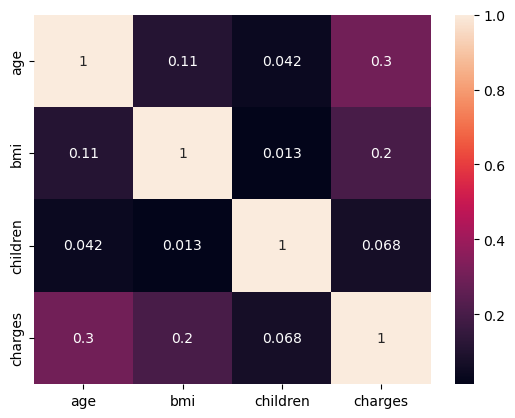

In [10]:
corr(df)

We do not have a collinearity problem.

# Cleaning Outliers

In [13]:
from cleaning import *

In [14]:
df_out = outlier_clean(df, features, method='median')

age has 0 values below min and 0 values above max
sex is categorial / dummy and was ignored
bmi has 0 values below min and 9 values above max
children has 0 values below min and 0 values above max
smoker is categorial / dummy and was ignored
region is categorial / dummy and was ignored


# Seperate features and target

In [41]:
df_f = df_out[features]
y = df_out[target]

# Encode Categorial Data

In [42]:
df_one_hot = pd.get_dummies(df_f, drop_first=True)
df_one_hot.head(5)

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


The number of columns is reasonable.

# Scaling

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [44]:
scaler.fit(df_one_hot)
df_scaled = pd.DataFrame(scaler.transform(df_one_hot), columns=df_one_hot.columns)
df_scaled.head(5)

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.447019,-0.908614,-1.010519,1.970587,-0.566418,-0.611324,1.765481
1,-1.509965,0.548269,-0.078767,0.989591,-0.507463,-0.566418,1.635795,-0.566418
2,-0.797954,0.417712,1.580926,0.989591,-0.507463,-0.566418,1.635795,-0.566418
3,-0.441948,-1.327857,-0.908614,0.989591,-0.507463,1.765481,-0.611324,-0.566418
4,-0.513149,-0.280855,-0.908614,0.989591,-0.507463,1.765481,-0.611324,-0.566418


In [46]:
X = df_scaled

The data now looks good-to-go.

# Model Selection

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [50]:
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
]

scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']

results = pd.DataFrame(columns = ['test_mse', 'test_mae'])

for model in models:
  cv_results = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
  results.loc[model.__class__.__name__] = [cv_results['test_neg_mean_squared_error'].mean(),
                                           cv_results['test_neg_mean_absolute_error'].mean(),
                                           ]

results

,test_mse,test_mae
DecisionTreeRegressor,-4.285961e+07,-3088.831429
RandomForestRegressor,-2.347740e+07,-2707.731388
AdaBoostRegressor,-2.900580e+07,-4326.511709
GradientBoostingRegressor,-2.139078e+07,-2540.877462


It seems that the GradientBoostingRegressor has the best performance.

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_data = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

<Axes: xlabel='y_test', ylabel='y_pred'>

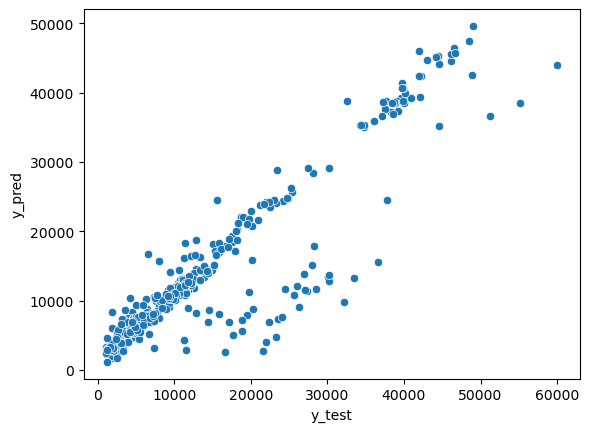

In [60]:
sns.scatterplot(data=y_data, x='y_test', y='y_pred')